In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np
import sys
import os
from PIL import Image
import json
from sklearn.utils import shuffle
from cache import cache
import pydot
import graphviz
from sklearn.model_selection import train_test_split
import time
import pickle
from tqdm import tqdm
import copy

In [6]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, LSTM, Embedding, Dropout,TimeDistributed, RepeatVector,\
Activation, Flatten, Reshape, concatenate, BatchNormalization

from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.applications.inception_v3 import preprocess_input as InceptionV3_preprocess_input
from tensorflow.python.keras.applications.vgg16 import preprocess_input as VGG16_preprocess_input
from tensorflow.python.keras.preprocessing import image

from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from tensorflow.python.keras.utils import plot_model
from tensorflow.python.keras.layers.merge import add
from tensorflow.python.keras.utils import to_categorical

In [7]:
tf.__version__

'1.14.0'

In [8]:
tf.keras.__version__

'2.2.4-tf'

In [9]:
tf.executing_eagerly()

True

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6620060110011540757
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11687644538924420450
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12182477449449062513
physical_device_desc: "device: XLA_GPU device"
]


In [11]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

# Download Data

In [12]:
os.path.abspath('.')

'/home/catnado/w266/final_project/Image_Caption'

In [13]:
# download caption file
if not os.path.exists(os.path.abspath('.') + '/annotations/'):
    annotation_zip = tf.keras.utils.get_file('captions.zip', 
                                              cache_subdir=os.path.abspath('.'),
                                              origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                              extract = True)
    annotation_file_train = os.path.abspath('.')+'/annotations/captions_train2014.json'
    annotation_file_val = os.path.abspath('.')+'/annotations/captions_val2014.json'
else:
    annotation_file_train = os.path.abspath('.')+'/annotations/captions_train2014.json'
    annotation_file_val = os.path.abspath('.')+'/annotations/captions_val2014.json'
    

In [14]:
print(annotation_file_train)
print(annotation_file_val)

/home/catnado/w266/final_project/Image_Caption/annotations/captions_train2014.json
/home/catnado/w266/final_project/Image_Caption/annotations/captions_val2014.json


In [15]:
# # download training set image file
# name_of_zip = 'train2014.zip'
# if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
#     image_zip = tf.keras.utils.get_file(name_of_zip,
#                                         cache_subdir=os.path.abspath('.') + '/train2014_try2/',
#                                         origin = 'http://images.cocodataset.org/zips/' + name_of_zip,
#                                         extract = True)
#     train_path = os.path.dirname(image_zip)+'/train2014/'
# else:
#     train_path = os.path.abspath('.')+'/train2014/'

In [16]:
train_path = os.path.abspath('.') + '/train2014/'
print(train_path)

/home/catnado/w266/final_project/Image_Caption/train2014/


In [17]:
# # download validation set image file
# name_of_zip = 'val2014.zip'
# if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
#     image_zip = tf.keras.utils.get_file(name_of_zip,
#                                         cache_subdir=os.path.abspath('.'),
#                                         origin = 'http://images.cocodataset.org/zips/' + name_of_zip,
#                                         extract = True)
#     val_path = os.path.dirname(image_zip)+'/val2014/'
# else:
#     val_path = os.path.abspath('.')+'/val2014/'

In [18]:
# print(train_path)
# print(val_path)

### Load data and limit size to 40,000

In [19]:
# Read the json file
with open(annotation_file_train, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = train_path + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

In [20]:
# # Shuffle captions and image_names together
# # Set a random state
# train_captions, img_name_vector = shuffle(all_captions,
#                                           all_img_name_vector,
#                                           random_state=1)

# # Select the first 30000 captions from the shuffled set
# num_examples = 40000
# train_captions = train_captions[:num_examples]
# img_name_vector = img_name_vector[:num_examples]

In [21]:
# len(train_captions), len(img_name_vector), len(all_captions)

### Load data and limit size to 40,000, but take only unique images and the first caption

In [22]:
# unique images with the first caption
unique_image_caption = dict(zip(all_img_name_vector, all_captions))
len(unique_image_caption)

82783

In [23]:
all_img_name_vector = list(unique_image_caption.keys())
all_captions = list(unique_image_caption.values())

In [24]:
# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 40000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [25]:
len(train_captions), len(img_name_vector), len(all_captions)

(40000, 40000, 82783)

### Full data

In [13]:
# # load training set
# with open(annotation_file_train, 'r') as f:
#     annotations = json.load(f)
    
# # storing the captions and the image name in vectorsa
# filenames_train = []
# captions_train = []

# for annot in annotations['annotations']:
#     caption = '<start> ' + annot['caption'] + ' <end>'
#     image_id = annot['image_id']
#     full_coco_image_path = train_path + 'COCO_train2014_' + '%012d.jpg' % (image_id)

#     filenames_train.append(full_coco_image_path)
#     captions_train.append(caption)
    
# unique_image_train = len(annotations['images'])

In [14]:
# # load validation set
# with open(annotation_file_val, 'r') as f:
#     annotations = json.load(f)
    
# # storing the captions and the image name in vectors
# filenames_val = []
# captions_val = []

# for annot in annotations['annotations']:
#     caption = '<start> ' + annot['caption'] + ' <end>'
#     image_id = annot['image_id']
#     full_coco_image_path = val_path + 'COCO_val2014_' + '%012d.jpg' % (image_id)

#     filenames_val.append(full_coco_image_path)
#     captions_val.append(caption)

# unique_image_val = len(annotations['images'])

In [21]:
# print("training set image: " + str(len(filenames_train)))
# print("training set unique image: " + str(unique_image_train))
# print("training set caption: " + str(len(captions_train)))

# print("validation set image: " + str(len(filenames_val)))
# print("validation set unique image: " + str(unique_image_val))
# print("validation set caption: " + str(len(captions_val)))

# Show Image

In [26]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [27]:
def show_image(path, caption):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    #path = filenames_train[idx]
    #caption = captions_train[idx]

    # Print the captions for this image.
    print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

<start> A train is pulling into a train station <end>


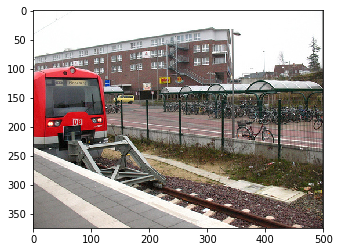

In [28]:
show_image(img_name_vector[8000], train_captions[8000])

# Encode Images with InceptionV3

### Encode with InceptionV3 layer[-3] for attention

In [19]:
# unique images
unique_images_train = sorted(set(filenames_train))
# unique_images_val = sorted(set(filenames_val))

In [23]:
# Get the InceptionV3 model trained on imagenet data
image_model2 = InceptionV3(weights='imagenet')
# Take -3 layer with shape (8,8,2048)
image_model_new2 = Model(image_model2.input, image_model2.layers[-3].output)

In [24]:
image_model_new2.output

<tf.Tensor 'mixed10/Identity:0' shape=(?, 8, 8, 2048) dtype=float32>

In [25]:
def load_image_for_inception(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = InceptionV3_preprocess_input(img)
    return img, image_path

In [41]:
# image_dataset = tf.data.Dataset.from_tensor_slices(unique_images_train)
# image_dataset = image_dataset.map(load_image_for_inception, 
#                                   num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

# for img, path in tqdm(image_dataset):
#     batch_features = image_model_new2(img)
#     batch_features = tf.reshape(batch_features,(tf.shape(batch_features)[0], -1, tf.shape(batch_features)[3]))

#     for bf, p in zip(batch_features, path):
#         path_of_feature = p.numpy().decode("utf-8")
#         np.save(path_of_feature, bf.numpy())
        
# # 82783 images, 64 batch size, expect 1294 batches

1294it [1:31:42,  3.66s/it]


In [21]:
# check loading image features
img_tensor = np.load(unique_images_train[-1]+'.npy')
img_tensor.shape

(64, 2048)

### For some reason some image features did not get saved. Rerunning for those images..

In [26]:
img_rerun = []
for img in unique_images_train:
    if not os.path.exists(img + '.npy'):
        img_rerun.append(img)

In [27]:
len(img_rerun)

4980

In [28]:
img_rerun[0]

'/home/catnado/w266/final_project/Image_Caption/train2014/COCO_train2014_000000116196.jpg'

In [29]:
# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(img_rerun)
image_dataset = image_dataset.map(load_image_for_inception, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

for img, path in tqdm(image_dataset):
    batch_features = image_model_new2(img)
    batch_features = tf.reshape(batch_features,(tf.shape(batch_features)[0], -1, tf.shape(batch_features)[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())
        
# 82783 images, 64 batch size, expect 1294 batches

78it [05:24,  3.85s/it]


In [30]:
img_rerun = []
for img in unique_images_train:
    if not os.path.exists(img + '.npy'):
        img_rerun.append(img)
len(img_rerun)

0

# Tokenize

In [29]:
vocab_size = 8000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

word_index = {key:value for key, value in tokenizer.word_index.items() if value <= vocab_size}
word_index['<pad>'] = 0
vocab_size += 1
index_word = {value:key for key, value in word_index.items()}

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = pad_sequences(train_seqs, padding='post')


# max number of tokens
max_length = np.max([len(t) for t in train_seqs])

In [30]:
print(train_captions[0])
print(train_seqs[0])
print(cap_vector[0])
print('max length: ', max_length)

<start> A very thin cow standing near a herd of elephants. <end>
[3, 2, 139, 1449, 250, 20, 39, 2, 324, 7, 220, 4]
[   3    2  139 1449  250   20   39    2  324    7  220    4    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
max length:  48


# Split Data

In [31]:
# Splitting to training, validation, test sets with 30K, 5K, 5K respectively
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.25,
                                                                    random_state=0)

img_name_val, img_name_test, cap_val, cap_test = train_test_split(img_name_val,
                                                                    cap_val,
                                                                    test_size=0.5,
                                                                    random_state=0)

In [32]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val), len(img_name_test), len(cap_test)

(30000, 30000, 5000, 5000, 5000, 5000)

# GloVe Embedding

In [30]:
# download GloVe vectors
if not os.path.exists(os.path.abspath('.') + '/GloVe/'):
    glove_zip = tf.keras.utils.get_file('glove_6B.zip',
                                        cache_subdir=os.path.abspath('.' + '/GloVe/'),
                                        origin = 'https://nlp.stanford.edu/data/glove.6B.zip',
                                        extract = True)

In [31]:
# Load Glove vectors
glove_dir = os.path.abspath('.' + '/GloVe/')
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [32]:
embedding_dim = 200
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [33]:
embedding_matrix.shape

(8001, 200)

# Merge Model with Attention

### Create a tf.data dataset for training

In [33]:
img_name_train = img_name_train[:29952]  #[:1024]  
cap_train = cap_train[:29952]  #[:1024]

In [34]:
len(img_name_train), len(cap_train)

(29952, 29952)

In [35]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = vocab_size
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [36]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [37]:
# test on 1000 images first
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Model

In [38]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, output):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        # output_with_time_axis = tf.expand_dims(output, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(output))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [39]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, units):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, hidden_size)
        self.fc = tf.keras.layers.Dense(units)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [182]:
# try 1
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # use glove embeddings
        #self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
        #                                           weights=[embedding_matrix], 
        #                                           trainable=False)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.fc0 = tf.keras.layers.Dense(attention_features_shape) # cc add

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # passing embedding to the GRU
        output, state = self.gru(x)
        
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, output)
        
        # pass output to a fc layer to get the same shape as attention feature (64)
        # x = self.fc0(output)
        
        # concatenate output and context vector
        # x shape after concatenation == (batch_size, 1, embedding_dim + output_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), output], axis=-1)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(x)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        state = tf.zeros((batch_size, self.units))
        state = tf.expand_dims(state, 1)
        return state

In [36]:
# try 2
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # use glove embeddings
        #self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
        #                                           weights=[embedding_matrix], 
        #                                           trainable=False)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc0 = tf.keras.layers.Dense(attention_features_shape)
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(self.units/2)
        self.fc3 = tf.keras.layers.Dense(vocab_size)
        

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, output):
        
        # use output vector as query to attend over image
        context_vector, attention_weights = self.attention(features, output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # passing embedding to the GRU
        new_output, state = self.gru(x)

        # pass output to a fc layer to get the same shape as attention feature (64) 
        # the idea is so that image and language gets equal weight
        # x = self.fc0(output)
        
        # concatenate output and context vector
        # x shape after concatenation == (batch_size, 1, embedding_dim + output_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), new_output], axis=-1)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(x)
        
        # adding an additional fc layer because the previous version did not perform well
        # x = self.fc2(x)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc3(x)

        return x, new_output, attention_weights

    def reset_state(self, batch_size):
        state = tf.zeros((batch_size, self.units))
        state = tf.expand_dims(state, 1)
        return state

In [40]:
# try 3
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # use glove embeddings
        #self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
        #                                           weights=[embedding_matrix], 
        #                                           trainable=False)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc0 = tf.keras.layers.Dense(attention_features_shape)
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(self.units/2)
        self.fc3 = tf.keras.layers.Dense(vocab_size)
        

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, output):
        
        # use output vector as query to attend over image
        context_vector, attention_weights = self.attention(features, output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # passing embedding to the GRU
        new_output, state = self.gru(x)

        # pass output to a fc layer to get the same shape as attention feature (64) 
        # the idea is so that image and language gets equal weight
        x = self.fc0(new_output)
        
        # concatenate output and context vector
        # x shape after concatenation == (batch_size, 1, embedding_dim + output_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(x)
        
        # adding an additional fc layer because the previous version did not perform well
        x = self.fc2(x)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc3(x)

        return x, new_output, attention_weights

    def reset_state(self, batch_size):
        state = tf.zeros((batch_size, self.units))
        state = tf.expand_dims(state, 1)
        return state

In [ ]:
# try 4
# this is try 2 with softmax
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # use glove embeddings
        #self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
        #                                           weights=[embedding_matrix], 
        #                                           trainable=False)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc0 = tf.keras.layers.Dense(attention_features_shape)
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(self.units/2)
        self.fc3 = tf.keras.layers.Dense(vocab_size)
        

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, output):
        
        # use output vector as query to attend over image
        context_vector, attention_weights = self.attention(features, output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # passing embedding to the GRU
        new_output, state = self.gru(x)

        # pass output to a fc layer to get the same shape as attention feature (64) 
        # the idea is so that image and language gets equal weight
        # x = self.fc0(output)
        
        # concatenate output and context vector
        # x shape after concatenation == (batch_size, 1, embedding_dim + output_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), new_output], axis=-1)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(x)
        
        # adding an additional fc layer because the previous version did not perform well
        # x = self.fc2(x)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc3(x)

        return x, new_output, attention_weights

    def reset_state(self, batch_size):
        state = tf.zeros((batch_size, self.units))
        state = tf.expand_dims(state, 1)
        return state

In [41]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

### Use GloVe embedding and set trainable to false

In [37]:
decoder.layers

In [72]:
# decoder.layers[0].set_weights([embedding_matrix])
# decoder.layers[0].trainable = False

In [105]:
# embedding_weights = tf.get_variable(
#     name='embedding_weights', 
#     shape=(vocab_size, embedding_dim), 
#     initializer=tf.constant_initializer(embedding_matrix),
#     trainable=False)

# embedding = tf.nn.embedding_lookup(embedding_weights, )

### Optimizer and loss function

In [38]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Checkpoint

In [39]:
checkpoint_path = "./checkpoints/attention_merge_v3/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [40]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1]) * 5

In [41]:
start_epoch

25

In [49]:
start_epoch = 20

### Restoring from Checkpoint

In [42]:
# restore from latest checkpoint
ckpt.restore(ckpt_manager.latest_checkpoint)
if ckpt_manager.latest_checkpoint:
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/attention_merge_v3/ckpt-5


In [43]:
ckpt_manager.checkpoints

['./checkpoints/attention_merge_v3/ckpt-1',
 './checkpoints/attention_merge_v3/ckpt-2',
 './checkpoints/attention_merge_v3/ckpt-3',
 './checkpoints/attention_merge_v3/ckpt-4',
 './checkpoints/attention_merge_v3/ckpt-5']

In [58]:
idx = 1
ckpt.restore(ckpt_manager.checkpoints[idx])
if ckpt_manager.checkpoints[idx]:
    print("Restored from {}".format(ckpt_manager.checkpoints[idx]))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/attention_merge/ckpt-2


### Training

In [44]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [45]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [46]:
# V2 on full data for 20 epochs
# trying V3 now..
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if (epoch+1) % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

W0730 14:55:41.056409 140097228023616 deprecation.py:323] From /home/catnado/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 11 Batch 0 Loss 0.6955
Epoch 11 Batch 100 Loss 0.6742
Epoch 11 Batch 200 Loss 0.6613
Epoch 11 Batch 300 Loss 0.6317
Epoch 11 Batch 400 Loss 0.6366
Epoch 11 Loss 0.664179
Time taken for 1 epoch 1302.7605390548706 sec

Epoch 12 Batch 0 Loss 0.6586
Epoch 12 Batch 100 Loss 0.6461
Epoch 12 Batch 200 Loss 0.6350
Epoch 12 Batch 300 Loss 0.6001
Epoch 12 Batch 400 Loss 0.6144
Epoch 12 Loss 0.634422
Time taken for 1 epoch 943.7784426212311 sec

Epoch 13 Batch 0 Loss 0.6324
Epoch 13 Batch 100 Loss 0.6239
Epoch 13 Batch 200 Loss 0.6160
Epoch 13 Batch 300 Loss 0.5797
Epoch 13 Batch 400 Loss 0.5957
Epoch 13 Loss 0.613447
Time taken for 1 epoch 953.6573774814606 sec

Epoch 14 Batch 0 Loss 0.6149
Epoch 14 Batch 100 Loss 0.5989
Epoch 14 Batch 200 Loss 0.6099
Epoch 14 Batch 300 Loss 0.5584
Epoch 14 Batch 400 Loss 0.5830
Epoch 14 Loss 0.597666
Time taken for 1 epoch 941.802553653717 sec

Epoch 15 Batch 0 Loss 0.5956
Epoch 15 Batch 100 Loss 0.5885
Epoch 15 Batch 200 Loss 0.5914
Epoch 15 Batch 300 Lo

In [50]:
# V2 on full data for 20 epochs
# trying V3 now..
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if (epoch+1) % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

W0730 20:53:21.254812 140447647242048 deprecation.py:323] From /home/catnado/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 17 Batch 0 Loss 0.6026
Epoch 17 Batch 100 Loss 0.5591
Epoch 17 Batch 200 Loss 0.5554
Epoch 17 Batch 300 Loss 0.5668
Epoch 17 Batch 400 Loss 0.5419
Epoch 17 Loss 0.568643
Time taken for 1 epoch 1338.2699360847473 sec

Epoch 18 Batch 0 Loss 0.5440
Epoch 18 Batch 100 Loss 0.5313
Epoch 18 Batch 200 Loss 0.5211
Epoch 18 Batch 300 Loss 0.5373
Epoch 18 Batch 400 Loss 0.5131
Epoch 18 Loss 0.539238
Time taken for 1 epoch 981.1766247749329 sec

Epoch 19 Batch 0 Loss 0.5218
Epoch 19 Batch 100 Loss 0.5124
Epoch 19 Batch 200 Loss 0.4995
Epoch 19 Batch 300 Loss 0.5221
Epoch 19 Batch 400 Loss 0.4970
Epoch 19 Loss 0.521671
Time taken for 1 epoch 976.7091562747955 sec

Epoch 20 Batch 0 Loss 0.5094
Epoch 20 Batch 100 Loss 0.4979
Epoch 20 Batch 200 Loss 0.4879
Epoch 20 Batch 300 Loss 0.5177
Epoch 20 Batch 400 Loss 0.4889
Epoch 20 Loss 0.509781
Time taken for 1 epoch 977.5513641834259 sec



In [46]:
start_epoch = 20

In [47]:
EPOCHS = 25

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if (epoch+1) % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

W0731 00:12:16.794250 140671093933888 deprecation.py:323] From /home/catnado/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 21 Batch 0 Loss 0.5326
Epoch 21 Batch 100 Loss 0.5000
Epoch 21 Batch 200 Loss 0.4838
Epoch 21 Batch 300 Loss 0.5195
Epoch 21 Batch 400 Loss 0.5114
Epoch 21 Loss 0.509181
Time taken for 1 epoch 1308.5257081985474 sec

Epoch 22 Batch 0 Loss 0.5001
Epoch 22 Batch 100 Loss 0.4905
Epoch 22 Batch 200 Loss 0.4640
Epoch 22 Batch 300 Loss 0.4993
Epoch 22 Batch 400 Loss 0.4889
Epoch 22 Loss 0.484848
Time taken for 1 epoch 961.2600486278534 sec

Epoch 23 Batch 0 Loss 0.4742
Epoch 23 Batch 100 Loss 0.4701
Epoch 23 Batch 200 Loss 0.4535
Epoch 23 Batch 300 Loss 0.4813
Epoch 23 Batch 400 Loss 0.4681
Epoch 23 Loss 0.472015
Time taken for 1 epoch 960.8665356636047 sec

Epoch 24 Batch 0 Loss 0.4696
Epoch 24 Batch 100 Loss 0.4698
Epoch 24 Batch 200 Loss 0.4432
Epoch 24 Batch 300 Loss 0.4775
Epoch 24 Batch 400 Loss 0.4714
Epoch 24 Loss 0.464578
Time taken for 1 epoch 963.3858840465546 sec

Epoch 25 Batch 0 Loss 0.4565
Epoch 25 Batch 100 Loss 0.4535
Epoch 25 Batch 200 Loss 0.4291
Epoch 25 Batch 300 L

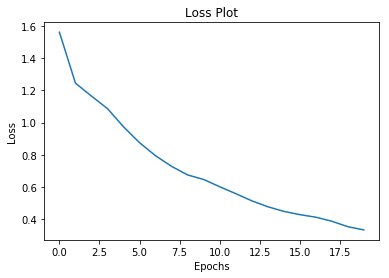

In [61]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Generate Caption

In [48]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(max(3, len_result//2), max(2, len_result//2), l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [49]:
def greedy_search(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
    img_tensor_val = np.load(image+'.npy')
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [50]:
def beam_search(image, k):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
    img_tensor_val = np.load(image+'.npy')
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([word_index['<start>']], 0)
      
    seq = [0] * max_length
    seq[0] = word_index['<start>']
    prob = 0
    all_candidates = [(seq, prob, hidden, attention_plot)]
    current_candidates = []

    for count in range(max_length-1):
        for i in range(len(all_candidates)):
            seq, prob, hidden, attention_plot = all_candidates[i]
            attention_plot = copy.deepcopy(attention_plot)
            dec_input = tf.expand_dims([seq[count]], 0)
            
            # if previously predicted <end>, do not make more prediction, add the current values to current_candidate
            if word_index['<end>'] in set(seq):
                current_candidates.extend([all_candidates[i]])
            
            else:
                predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
                attention_plot[count] = tf.reshape(attention_weights, (-1, )).numpy()

                predictions = predictions[0].numpy()
                pred_word = np.argsort(predictions)[-k:][::-1]
                pred_prob = predictions[pred_word]

                pred_prob = (prob*count + pred_prob)/(count+1)
                pred_seq = []
                for word in pred_word:
                    seq2 = copy.deepcopy(seq)
                    seq2[count+1] = word
                    pred_seq.append(seq2)

                pred_hidden = [hidden] *k
                pred_att_plot = [attention_plot] *k

                current_candidates.extend(zip(pred_seq, pred_prob, pred_hidden, pred_att_plot))
        
        #print(count)
        ordered = sorted(current_candidates, key=lambda tup:tup[1], reverse=True)
        all_candidates = ordered[:k]
        current_candidates = []
        count += 1
        

    # final result
    ordered = sorted(all_candidates, key=lambda tup:tup[1], reverse=True)
    result = ordered[0][0]
    attention_plot = ordered[0][3]
    result = [index_word[i] for i in result if i != 0]
    result = result[1:]
    #result = ' '.join(result)

    return result, attention_plot

Real Caption: <start> children in black and orange shirts kicking a soccer ball <end>
Predicted Caption: a young men kicking a field <end>


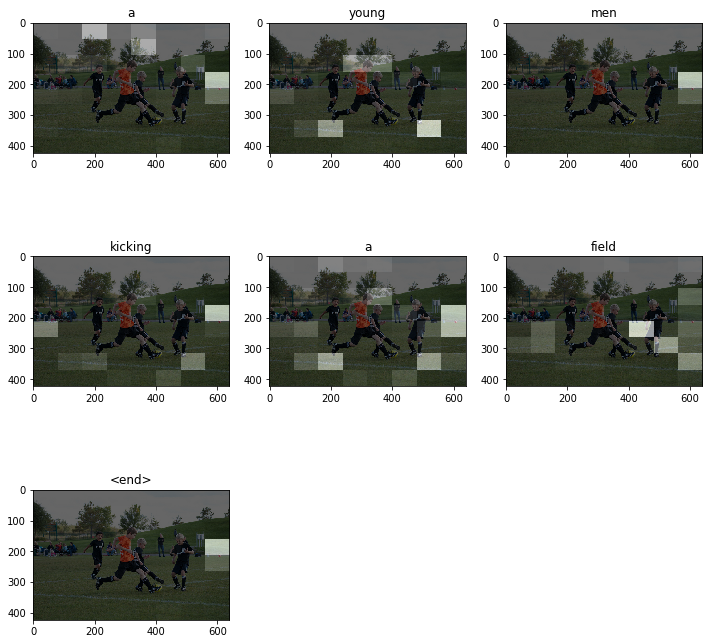

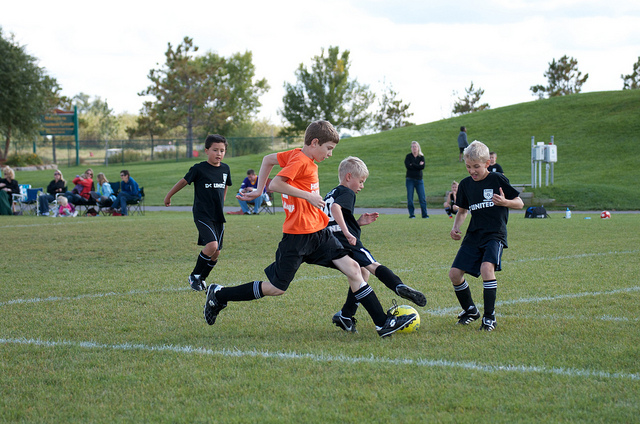

In [53]:
# caption with beam search
img = 10
image = img_name_val[img]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[img] if i not in [0]])
result, attention_plot = beam_search(image, 3)
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(img_name_val[img])

Real Caption: <start> a close up of a pizza on a black surface <end>
Predicted Caption: a pizza on a metal tray <end>


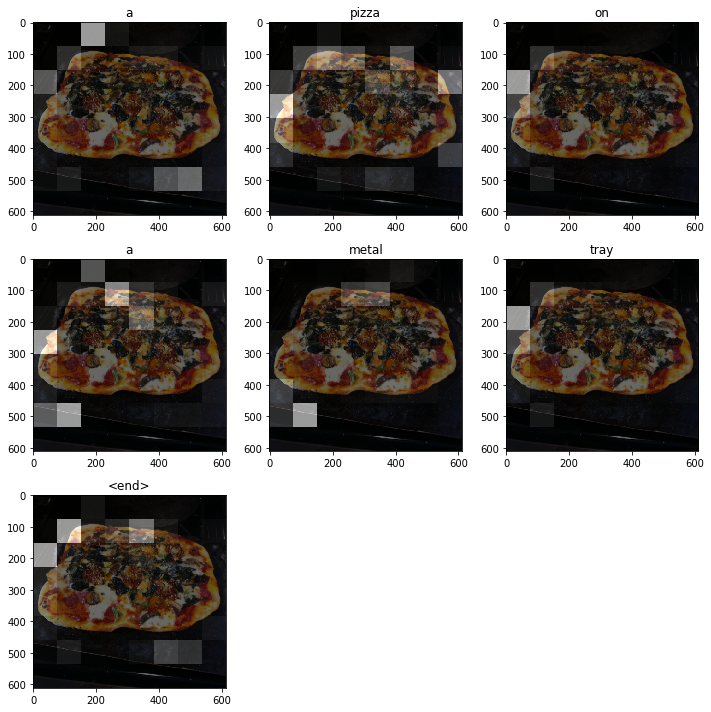

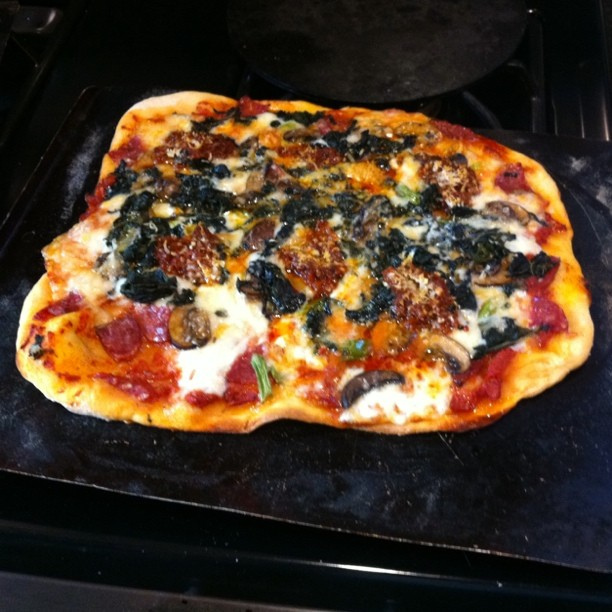

In [68]:
# caption with greedy search
img = 14
image = img_name_val[img]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[img] if i not in [0]])
result, attention_plot = greedy_search(image)
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(img_name_val[img])

# Generate Caption for Entire Test Set

In [69]:
# same greedy search without generating attention_plot to save some space/time
def caption_greedy(image):
    hidden = decoder.reset_state(batch_size=1)
    img_tensor_val = np.load(image+'.npy')
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if index_word[predicted_id] == '<end>':
            return ' '.join(result[:-1])

        dec_input = tf.expand_dims([predicted_id], 0)

    return ' '.join(result[:-1])

In [70]:
caption_greedy(image)

'a pizza on a metal tray'

In [71]:
# same beam search without generating attention_plot to save some space/time
def caption_beam(image, k):
    hidden = decoder.reset_state(batch_size=1)
    img_tensor_val = np.load(image+'.npy')
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([word_index['<start>']], 0)
      
    seq = [0] * max_length
    seq[0] = word_index['<start>']
    prob = 0
    all_candidates = [(seq, prob, hidden)]
    current_candidates = []

    for count in range(max_length-1):
        for i in range(len(all_candidates)):
            seq, prob, hidden = all_candidates[i]
            dec_input = tf.expand_dims([seq[count]], 0)
            
            # if previously predicted <end>, do not make more prediction, add the current values to current_candidate
            if word_index['<end>'] in set(seq):
                current_candidates.extend([all_candidates[i]])
            
            else:
                predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
                predictions = predictions[0].numpy()
                pred_word = np.argsort(predictions)[-k:][::-1]
                pred_prob = predictions[pred_word]

                pred_prob = (prob*count + pred_prob)/(count+1)
                pred_seq = []
                for word in pred_word:
                    seq2 = copy.deepcopy(seq)
                    seq2[count+1] = word
                    pred_seq.append(seq2)

                pred_hidden = [hidden] *k
                
                current_candidates.extend(zip(pred_seq, pred_prob, pred_hidden))
        
        #print(count)
        ordered = sorted(current_candidates, key=lambda tup:tup[1], reverse=True)
        all_candidates = ordered[:k]
        current_candidates = []
        count += 1
        

    # final result
    ordered = sorted(all_candidates, key=lambda tup:tup[1], reverse=True)
    result = ordered[0][0]
    result = [index_word[i] for i in result if i != 0]
    result = result[1:-1]
    result = ' '.join(result)

    return result

In [72]:
caption_beam(image, 3)

'two pizzas are being cooked'

### Generate greedy search captions

In [73]:
import re

In [74]:
pred_caption = []
for i in range(len(img_name_test)):
    caption = caption_greedy(img_name_test[i])
    caption = re.sub('\n', '', caption)
    pred_caption.append(caption)
    if i%500 == 0:
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [75]:
len(pred_caption)

5000

In [76]:
pred_caption[:10]

['a man is on a barbed wire',
 'a man is parked on a building',
 'a woman is playing video game controllers',
 'a man on a skateboard',
 'a baseball player is swinging a baseball player is swinging a baseball player is swinging a baseball player is swinging a baseball player is swinging a baseball player is swinging a baseball player is swinging a baseball player is swinging a baseball player is swinging a baseball',
 'a boat in a boat in a boat in a boat in a boat in a boat in a boat in a boat in a boat in a boat in a boat in a boat in a boat in a boat in a boat in a boat',
 'a man in a refrigerator',
 'a man riding on a motorcycle',
 'a black and white shirt is wearing a black and white shirt is wearing a black and white shirt is wearing a black and white shirt is wearing a black and white shirt is wearing a black and white shirt is wearing a black and white shirt',
 'a horse']

In [77]:
with open('evaluation/attention_merge_v3_greedy.txt', 'w') as f:
    for i in pred_caption:
        f.write("%s\n" % i)

In [1]:
!wc -l evaluation/attention_merge_v3_greedy.txt

5000 evaluation/attention_merge_v3_greedy.txt


# Evaluation

In [2]:
from nlgeval import compute_metrics
from nlgeval import compute_individual_metrics

In [4]:
metrics_dict = compute_metrics(hypothesis='evaluation/attention_merge_v2_greedy.txt',
                               references=['evaluation/true_caption.txt'])

Bleu_1: 0.156915
Bleu_2: 0.073808
Bleu_3: 0.036488
Bleu_4: 0.018208
METEOR: 0.076825
ROUGE_L: 0.203750
CIDEr: 0.252946
SkipThoughtsCosineSimilairty: 0.445791
EmbeddingAverageCosineSimilairty: 0.750937
VectorExtremaCosineSimilarity: 0.460145
GreedyMatchingScore: 0.609437


In [3]:
metrics_dict = compute_metrics(hypothesis='evaluation/attention_merge_v3_greedy.txt',
                               references=['evaluation/true_caption.txt'])

Bleu_1: 0.148785
Bleu_2: 0.073078
Bleu_3: 0.036274
Bleu_4: 0.018192
METEOR: 0.084207
ROUGE_L: 0.218950
CIDEr: 0.272753


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


SkipThoughtsCosineSimilairty: 0.459908
EmbeddingAverageCosineSimilairty: 0.791808
VectorExtremaCosineSimilarity: 0.483641
GreedyMatchingScore: 0.642542


# End of Main Code

### Debug stuff

In [321]:
image = img_name_train[0]
attention_plot = np.zeros((max_length, attention_features_shape))
hidden = decoder.reset_state(batch_size=1)
img_tensor_val = np.load(image+'.npy')
features = encoder(img_tensor_val)
dec_input = tf.expand_dims([word_index['<start>']], 0)

seq = [0] * max_length
seq[0] = word_index['<start>']
prob = 0
all_candidates = [(seq, prob, hidden, attention_plot)]
current_candidates = []

In [426]:
# for count in range(max_length)
count = 3

In [454]:
# for i in range(len(all_candidates)):
i = 2

In [455]:
seq, prob, hidden, attention_plot = all_candidates[i]
dec_input = tf.expand_dims([seq[count]], 0)

In [457]:
predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
attention_plot[count] = tf.reshape(attention_weights, (-1, )).numpy()

In [458]:
predictions = predictions[0].numpy()
pred_word = np.argsort(predictions)[-3:][::-1]
pred_word

array([  2, 430,  56])

In [459]:
predictions

array([-9.61376 ,  7.605274, 12.695165, ..., -9.915413, -9.927469,
       -9.098779], dtype=float32)

In [460]:
pred_prob = predictions[pred_word]
pred_prob

array([12.695165, 11.364677, 11.135266], dtype=float32)

In [461]:
pred_prob = (prob*count + pred_prob)/(count+1)
pred_prob

array([15.506205, 15.173583, 15.11623 ], dtype=float32)

In [462]:
pred_seq = []
for word in pred_word:
    seq2 = copy.deepcopy(seq)
    seq2[count+1] = word
    pred_seq.append(seq2)

In [463]:
pred_hidden = [hidden] *3
pred_att_plot = [attention_plot] *3

In [464]:
current_candidates.extend(zip(pred_seq, pred_prob, pred_hidden, pred_att_plot))

In [465]:
len(current_candidates)

7

In [466]:
# end of i loop

In [467]:
ordered = sorted(current_candidates, key=lambda tup:tup[1], reverse=True)
all_candidates = ordered[:3]
current_candidates = []
#count += 1

In [468]:
len(all_candidates)

3

# Inject Model

In [ ]:
state_size = 512
embedding_size = 128

# encoder
encoder_input = Input(shape=(transfer_values_size,), name='encoder_input')
encoder_output = Dense(state_size, activation='tanh', name='encoder_output') 
# using tanh to get to -1 to 1 in order to use as initial state

# decoder
decoder_input = Input(shape=(None, ), name='decoder_input')
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_size, name='decoder_embedding')
decoder_gru1 = GRU(state_size, return_sequences=True, name='decoder_gru1')
decoder_gru2 = GRU(state_size, return_sequences=True, name='decoder_gru2')
decoder_gru3 = GRU(state_size, return_sequences=True, name='decoder_gru3')
decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_output')

# connect layers
initial_state = encoder_output(encoder_input)
net = decoder_embedding(decoder_input)
net = decoder_gru1(net, initial_state=initial_state)
net = decoder_gru2(net, initial_state=initial_state)
net = decoder_gru3(net, initial_state=initial_state)
decoder_output = decoder_dense(net)


# connect and create model
model = Model(inputs=[encoder_input, decoder_input], outputs=decoder_output)


In [ ]:
print(model.summary())

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# checkpoint
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
callback_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# tensorboard
callback_tensorboard = TensorBoard(log_dir='./tensorboard_logs/', histogram_freq=0, write_graph=False)

callbacks = [callback_checkpoint, callback_tensorboard]

In [ ]:
# load model
try:
    model.load_weights(filepath)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [ ]:
# compile model
rms = RMSprop(lr=0.001)  #RMS prop works better than adam for RNN models
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=rms)


In [ ]:
check_X1train = 

In [ ]:
# fit model
# should train for 20, try 1 for now
%time
model.fit([check_X1train, check_X2train], check_ytrain, epochs=3, verbose=2, callbacks=callbacks, 
          validation_data=([check_X1val, check_X2val], check_yval))

# Generate Caption

In [ ]:
def generate_caption(idx, max_tokens=51):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # input X1: transfer values
    transfer_values = X1train[idx].reshape((1, 4096))
    
    # input X2: word token
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    token_int = tokenizer.word_index['<start>']
    token_end = tokenizer.word_index['<end>']
    output_text = ''
    count_tokens = 0


    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        
        decoder_input_data[0, count_tokens] = token_int
        decoder_output = model.predict([transfer_values, decoder_input_data])
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)
        if token_int != 0:
            sampled_word = index_word[token_int]
            output_text += " " + sampled_word
        else:
            break
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    show_image(idx)
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()